In [5]:
# !pip install tensorflow-gpu --upgrade

In [6]:
# Import libraries
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from src.layers import CADenseAdd, CADenseMul
from src.optimizers import SVDAdam, SVDSGD
from src.models import wrap_model

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import tensorflow as tf

import types 
import os

plt.style.use('dark_background')

In [7]:
# Directories
covid_data = 'IndianCovidData/CovidData'
state_data = 'IndianCovidData/StateData'

In [8]:
smoothing_window = 5

# Covid data per state
covid_per_state = {
    file[:-4]: pd.read_csv(os.path.join(covid_data, file), delimiter=',', index_col=0, usecols=[1, 2, 3, 4, 5]) 
    for file in os.listdir(covid_data) if file.endswith('csv')
}
# Shift and scale
for state, df in covid_per_state.items():
    for i in ['Confirmed', 'Recovered', 'Deceased']:
        scaled = df[i].apply(lambda x: np.log(1 + x))
        shifted = scaled - scaled.shift(1)
        shifted = shifted.rolling(smoothing_window).mean().dropna()
        shifted[shifted < 10e-6] = np.nan
        shifted = shifted.interpolate()
        df[f'ShiftedScaled{i}'] = shifted
        covid_per_state[state] = df.dropna()

    
# Full dataframe
covid_df = pd.concat(covid_per_state, axis=0)

In [9]:
# States in data
states = covid_df.State.unique()

In [10]:
# State data per property
property_per_state = {
    prop: pd.read_csv(
        os.path.join(state_data, prop), delimiter=';', skiprows=0, nrows=36, header=0, index_col=0, na_values=['-', '.'])
    for prop in os.listdir(state_data) if prop.endswith('csv')
}
# Map states between two dataset
mapping = {
    idx: state for idx in pd.concat([pd.Series(df.index) for df in property_per_state.values()]).values for state in states 
    if any([token in state for token in str(idx).split('&')])
}
# Get state data rows and most recent data
for prop, df in property_per_state.items():
    property_per_state[prop] = df.T[list(set(df.index) & set(mapping.keys()))].T[df.columns[-1]]

In [11]:
# Concatenate all properties
state_df = pd.concat(property_per_state.values(), axis=1).applymap(lambda s: float(str(s).replace(',', '.'))).fillna(0)
state_df.columns = [''.join(df.index.name.split(': ')[1:]) for df in property_per_state.values()]
state_df = state_df.divide(state_df.max())

In [12]:
def split_series(series, percentage=0.8):
    return series[:int(percentage * series.size)].values, series[int(percentage * series.size):].values, 

percentage = 0.6
train_series, test_series = zip(*[split_series(series.ShiftedScaledConfirmed, percentage) for series in covid_per_state.values()])

## ARIMA

In [34]:
import statsmodels.api as sm

warnings.filterwarnings("ignore")

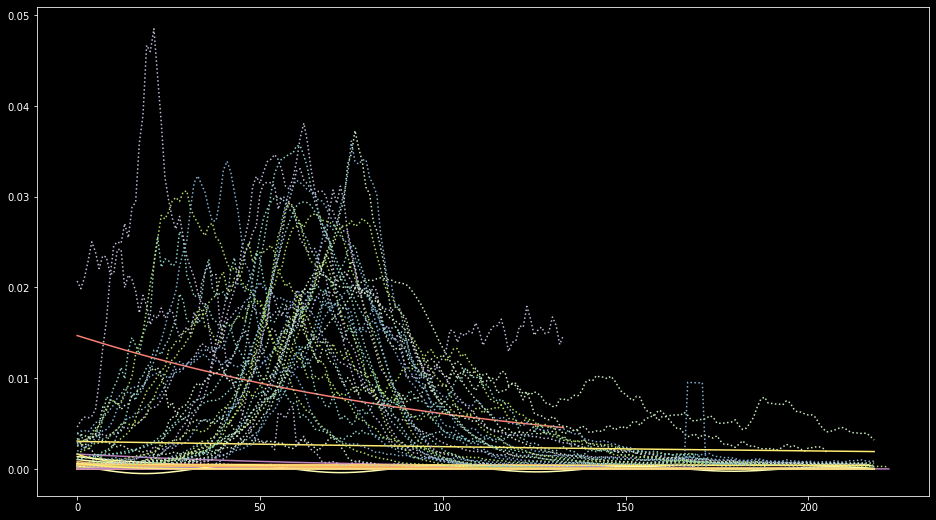

In [84]:
plt.figure(figsize=(16, 9))
models = {}

for state, series in covid_per_state.items():
    l = int(series.ShiftedScaledConfirmed.size * 0.4)
    model = sm.tsa.SARIMAX(series.ShiftedScaledConfirmed.values, order=(2,0,0))
    models[state] = model.fit(disp=False)
    pred = models[state].forecast(l)
    plt.plot(series.ShiftedScaledConfirmed.values[-l:], linestyle='dotted')
    plt.plot(pred)

0.08069888667839231

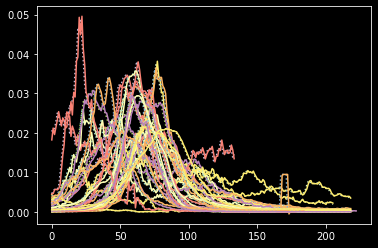

In [81]:
a = []
plt.figure(figsize=(16, 9))
for state, series in covid_per_state.items():
    l = int(series.ShiftedScaledConfirmed.size * 0.4)
    pred = []
    for i in range(l):
        model = sm.tsa.SARIMAX(series.ShiftedScaledConfirmed.values[:-l + i], order=(0,1,1))
        model = model.fit(disp=False)
        pred.append(model.forecast(1))
    true = series.ShiftedScaledConfirmed.values[-l:]
    plt.plot(true, linestyle='dotted')
    plt.plot(pred)
    a.append(np.mean(np.abs(true - pred)))
np.sqrt(np.mean(a))

0.0807177140225542

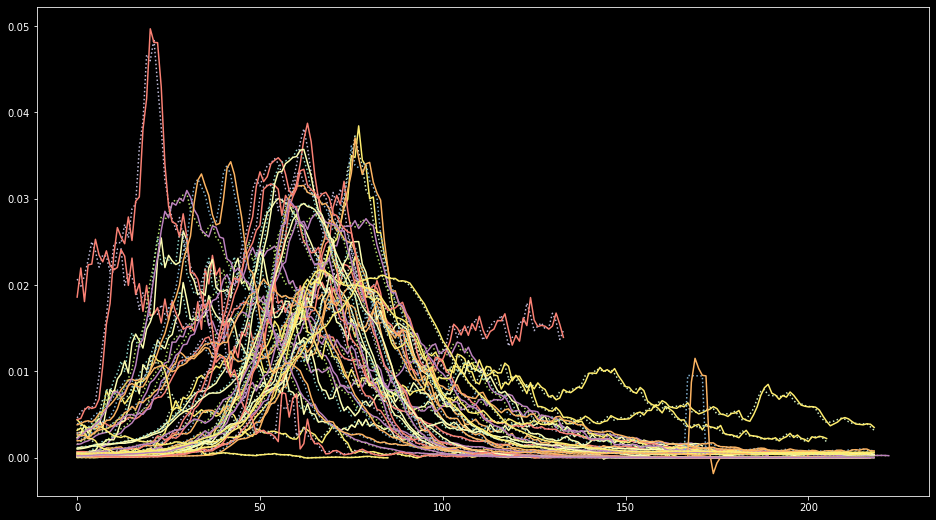

In [83]:
a = []
plt.figure(figsize=(16, 9))
for state, series in covid_per_state.items():
    l = int(series.ShiftedScaledConfirmed.size * 0.4)
    pred = []
    for i in range(l):
        model = sm.tsa.SARIMAX(series.ShiftedScaledConfirmed.values[:-l + i], order=(3, 1, 1))
        model = model.fit(disp=False)
        pred.append(model.forecast(1))
    true = series.ShiftedScaledConfirmed.values[-l:]
    plt.plot(true, linestyle='dotted')
    plt.plot(pred)
    a.append(np.mean(np.abs(true - pred)))
np.sqrt(np.mean(a))

### MLP Multiple models

In [13]:
def split_series(series, percentage=0.8):
    return series[:int(percentage * series.size)].values, series[int(percentage * series.size):].values, 

percentage = 0.6
train_series, test_series = zip(*[split_series(series.ShiftedScaledConfirmed, percentage) for series in covid_per_state.values()])

## Convnet

In [ ]:
learning_rate = 10e-5
epochs = 25
verbose = 0

def build_loss():
    def loss_fn(y_true, y_pred):
        return tf.reduce_sum(
            (tf.math.exp(y_true) - tf.math.exp(y_pred))**2
        )
    return loss_fn

loss = build_loss()

In [66]:
def lstm(nn):
#     nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))(nn)
#     nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='elu'))(nn)
    nn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu'))(nn)
    return nn

def mlp(nn, nc=None):
    n_layers = 1
    if nc is not None:
        for i in range(n_layers):
            nn = CADenseMul(64, 16, 'relu', use_bias=False)([nn, nc])
    else:
        for i in range(n_layers):
            nn = tf.keras.layers.Dense(64, 'relu', use_bias=False)(nn)
    return nn

### Only TS data

In [56]:
def window(series, stride, window_size, target_size):
    for serie in series:
        for idx in np.arange(0, serie.size - window_size - target_size, stride):
            yield serie[idx:idx + window_size, np.newaxis], serie[idx + window_size:idx + window_size + target_size, ...]

window_size = 14
target_size = 1
stride = 7

In [57]:
batch_size = 64
datasets = {}

for state, series in covid_per_state.items():
    train_series, test_series = split_series(series.ShiftedScaledConfirmed, percentage)
    datasets[state] = tf.data.Dataset.from_generator(
        lambda: window([train_series], stride, window_size, target_size), 
        output_shapes=((window_size, 1), (target_size)),
        output_types=(tf.float32, tf.float32)
    ).batch(batch_size).shuffle(128 * batch_size)

In [73]:
nn = input_layer = tf.keras.layers.Input(shape=(window_size, 1))
nn = lstm(nn)
# nn = tf.reduce_max(nn, axis=-2)
# nn = tf.reshape(nn, [-1, window_size])
nn = mlp(nn)
nn = tf.keras.layers.Dense(target_size, use_bias=True)(nn)

In [74]:
models = {}
histories = {}
for state, dataset in datasets.items():
    model = tf.keras.Model(input_layer, nn)
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss=loss, optimizer=opt)
    history = model.fit(dataset, epochs=epochs, verbose=verbose)
    models[state] = model
    histories[state] = history

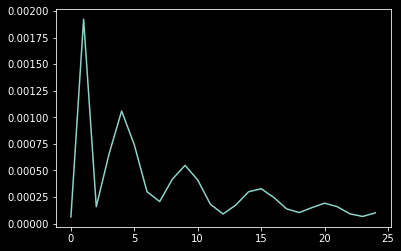

In [75]:
plt.plot(history.history['loss'])
plt.show()

In [76]:
def predict(model, series, forecast=True):
    predictions = []
    for serie in series:
        prediction = serie[np.newaxis, :window_size, np.newaxis]
        for i in range(serie.size - window_size):
            if forecast:
                value = model(prediction[:, i:window_size + i, :])
            else:
                value = model(serie[np.newaxis, i:window_size + i, np.newaxis])
            prediction = np.concatenate([prediction, value[..., np.newaxis]], axis=-2)
        predictions.append(prediction)
    return predictions

In [77]:
predictions = {}
test_series_dict = {}
for state, series in covid_per_state.items():
    train_series, test_series = split_series(series.ShiftedScaledConfirmed, percentage)
    predictions[state] = predict(model, [test_series], False)
    test_series_dict[state] = test_series

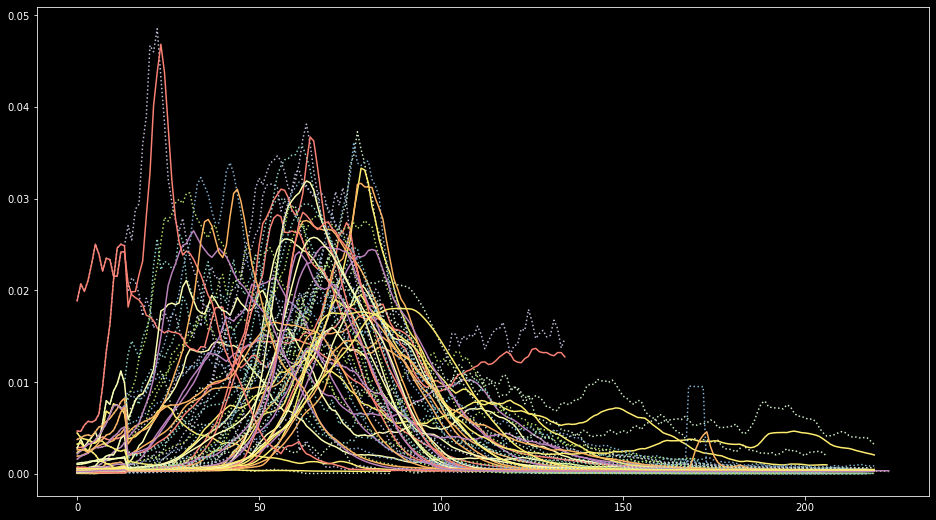

In [78]:
plt.figure(figsize=(16, 9))
for true, pred in zip(test_series_dict.values(), predictions.values()):
    plt.plot(true, linestyle='dotted')
    plt.plot(pred[0][0, :, 0])
plt.show()

In [79]:
test_ae = np.sqrt(np.mean([
    np.mean(np.abs(true - pred[0][0, :, 0])) for true, pred in zip(test_series_dict.values(), predictions.values())]))
